# This Notebook Include:
* Goal of DataSet and About the Data Sheet
* Data Visualization
* Approach and Guide to do the Modeling ( Begineer Friendly )
* Statistics ( Both Discriptive and Infrential Statistics )

# **GOAL OF DATASET**

Develop a **AI model that can automatically identify bird species** from soundscape recordings, even in noisy environments with overlapping vocalizations from El Silencio Natural Reserve, Colombia, to aid biodiversity monitoring

**Real World Applications**

This has real-world applications in:

* Biodiversity monitoring
* Conservation efforts
* Ecological research



# **A. About Data------------->**

The data consist of 3 Folder as well as 4 files ( you could see Right ) for Training, Testing, Taxonomony, etc as discussed below : 

## 1) **train_audio File**

Short, single-species recordings (.ogg format, 32 kHz). Filename format: collection > file_id > ogg files (e.g., CSA36385.ogg). This is the Folder to be Trained.

Link : /kaggle/input/birdclef-2025/train_audio

## 2. Train-Soundscape File

Contains 1-min unlabeled soundscapes helpful for Model adaptation to real-world conditions with **No** Noise. 

## 3. **test_soundscapes**

Only contains ReadMe.txt file. it's of no use in both training and testing
Link : /kaggle/input/birdclef-2025/test_soundscapes

## 4. **recording-location.txt**

Just contains the address and Website. Not helpful in Training and Testing

## 5. **taxonomy.csv**

Just contains the Taxonomy CSV useful for Reserach. Contains Scientific Name, Common Name and their Class Name of Taxon. Not useful !

## 6. **train.csv**

The train.csv contains Reference for each Bird Sound. Here "filename" contains the Exact File Name of the Bird Referenced to "scientific_name" and 'common_name'. This is most important for Training the Bird data and referencing to the Bird Name.

# **B. Data Viusalization--------------->**

## 1. **Visualizing Audio Waveforms**

Understand raw audio signals (amplitude vs. time) to Detect clipping, silence, or unusual patterns

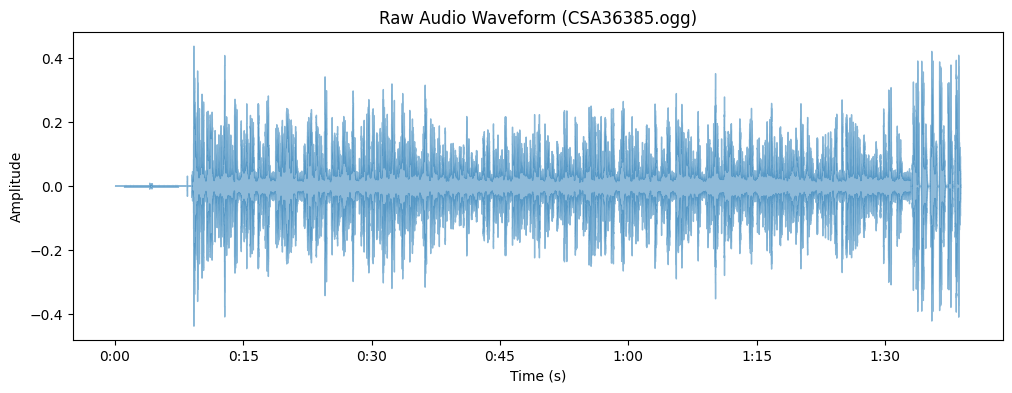

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt


audio_path = "/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg"
y, sr = librosa.load(audio_path, sr=32000)  # Sample rate = 32 kHz


plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title("Raw Audio Waveform (CSA36385.ogg)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Could you see the Continuity of Sound? SO SO NOISY........With great ups and downs.... Well, Now Run this Graph

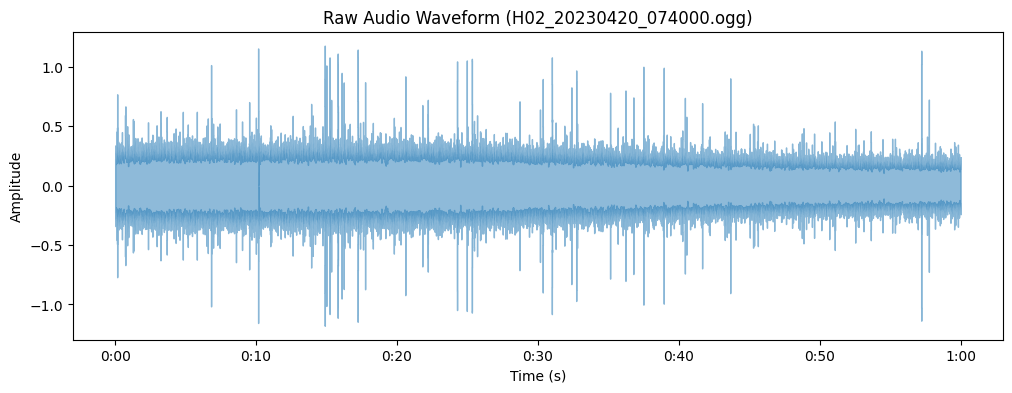

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt


audio_path = "/kaggle/input/birdclef-2025/train_soundscapes/H02_20230420_074000.ogg"
y, sr = librosa.load(audio_path, sr=32000)  


plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title("Raw Audio Waveform (H02_20230420_074000.ogg)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Could you understand difference between **train_audio** as well as **train_soundscape**. As already told latter will be contains Sound without Background Interference

You could use other Sounds to Visualize !!!

## 2. **Spectrograms (Time-Frequency Analysis)**

Let's Identify dominant frequencies like bird calls over time

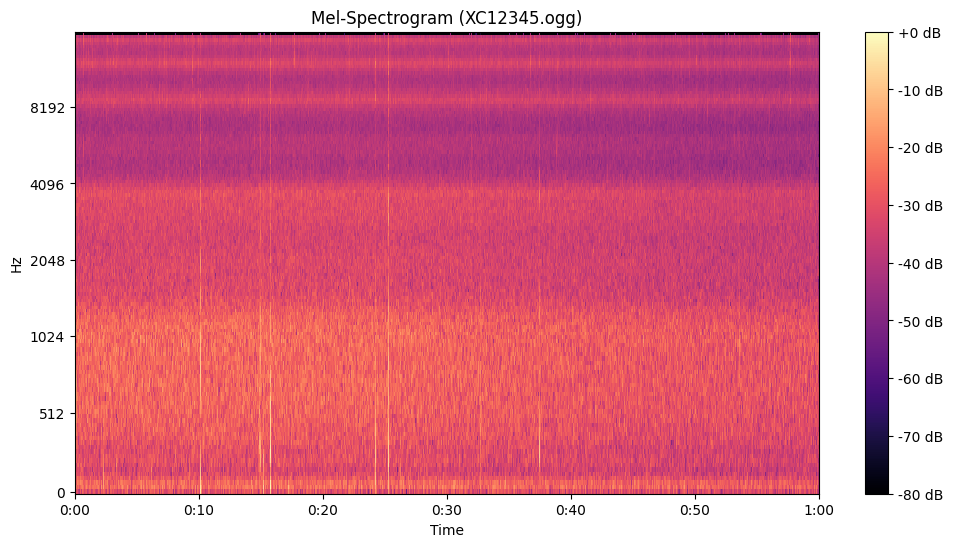

In [3]:
import numpy as np
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=16000)
S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB

# Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=16000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (XC12345.ogg)")
plt.show()

So Most of them remain around 10-20Db sound in most of Audio

## 3. **Feature Distributions (EDA)**

**Species Distribution**

To Detect class imbalance, recording quality, or geographic bias

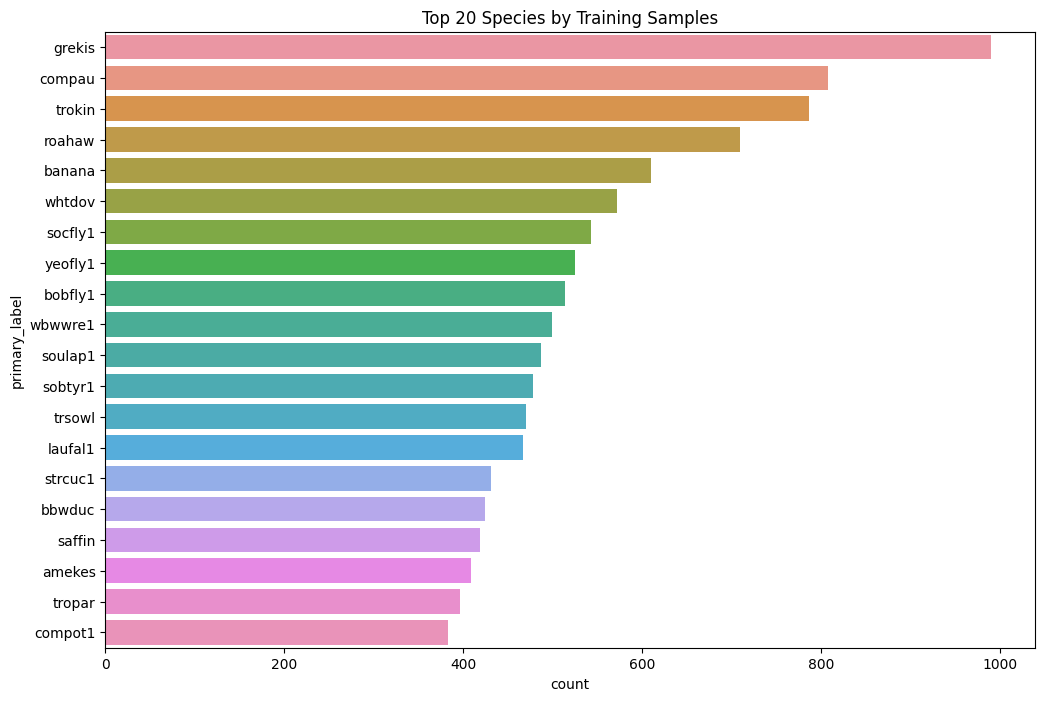

In [4]:
import seaborn as sns
import pandas as pd

train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")

plt.figure(figsize=(12, 8))
sns.countplot(data=train_df, y="primary_label", order=train_df["primary_label"].value_counts().index[:20])  # Top 20 species
plt.title("Top 20 Species by Training Samples")
plt.show()

You could see grekis as the Popular Bird. So, Even if your ML Model Prdict grekis only, you are 50% more correct than nothing :)

**Recording Quality (Rating Distribution)**

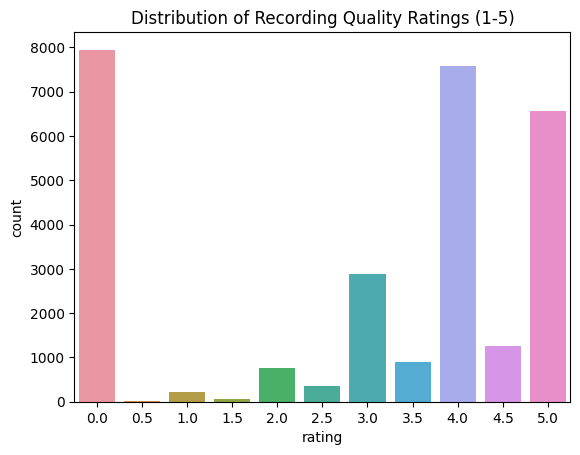

In [5]:
sns.countplot(data=train_df, x="rating")
plt.title("Distribution of Recording Quality Ratings (1-5)")
plt.show()

You could see most have 0.0 Rating? It's becuase of Incomplete data. While you should be happy that 4.0 have 2nd Most Rated Data, so your ML Data is Safe

**Geographic Clustering (Lat/Long)**

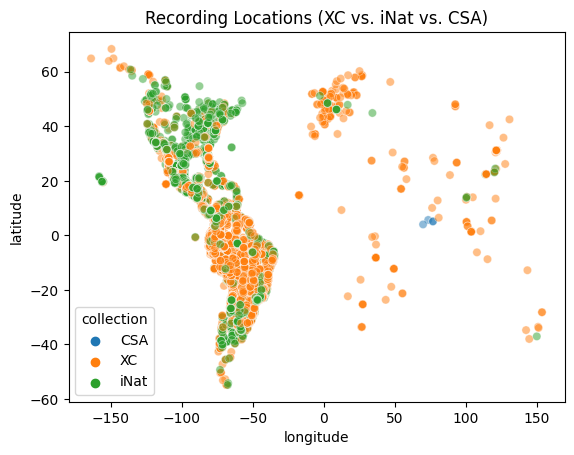

In [6]:
sns.scatterplot(data=train_df, x="longitude", y="latitude", alpha=0.5, hue="collection")
plt.title("Recording Locations (XC vs. iNat vs. CSA)")
plt.show()

You see most species are from America, so the Birds presented here are Native Singers of America Land.

## 4. **Call Duration Analysis**

Check if call lengths vary by species (affects segmentation)

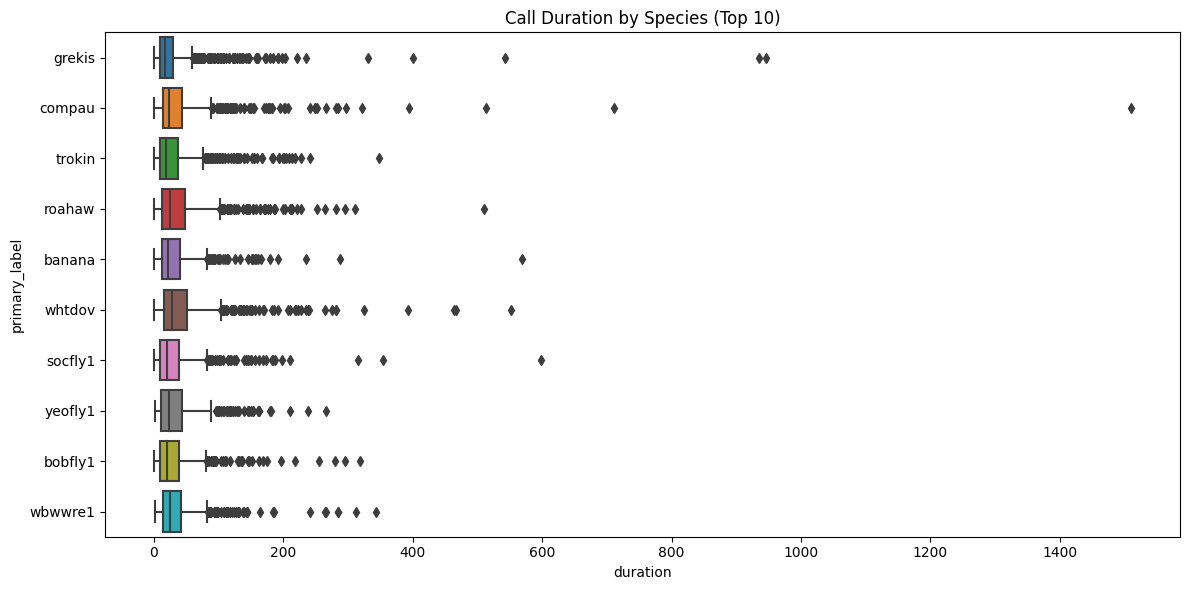

In [7]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load metadata
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")

def get_duration_safe(row):
    audio_path = os.path.join("/kaggle/input/birdclef-2025/train_audio",  
                            row['filename'])
    try:
        return librosa.get_duration(path=audio_path)  # Use 'path' instead of 'filename'
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None  # Return None for missing files

train_df["duration"] = train_df.apply(get_duration_safe, axis=1)

# Drop rows with missing durations
train_df = train_df.dropna(subset=['duration'])

# Plot top 10 species by duration
plt.figure(figsize=(12, 6))
top_species = train_df["primary_label"].value_counts().index[:10]
sns.boxplot(
    data=train_df[train_df["primary_label"].isin(top_species)],
    x="duration",
    y="primary_label",
    order=top_species
)
plt.title("Call Duration by Species (Top 10)")
plt.tight_layout()  # Prevent label cutoff
plt.show()

## 5. **Background Noise**

Compare bg noise in train_soundscape

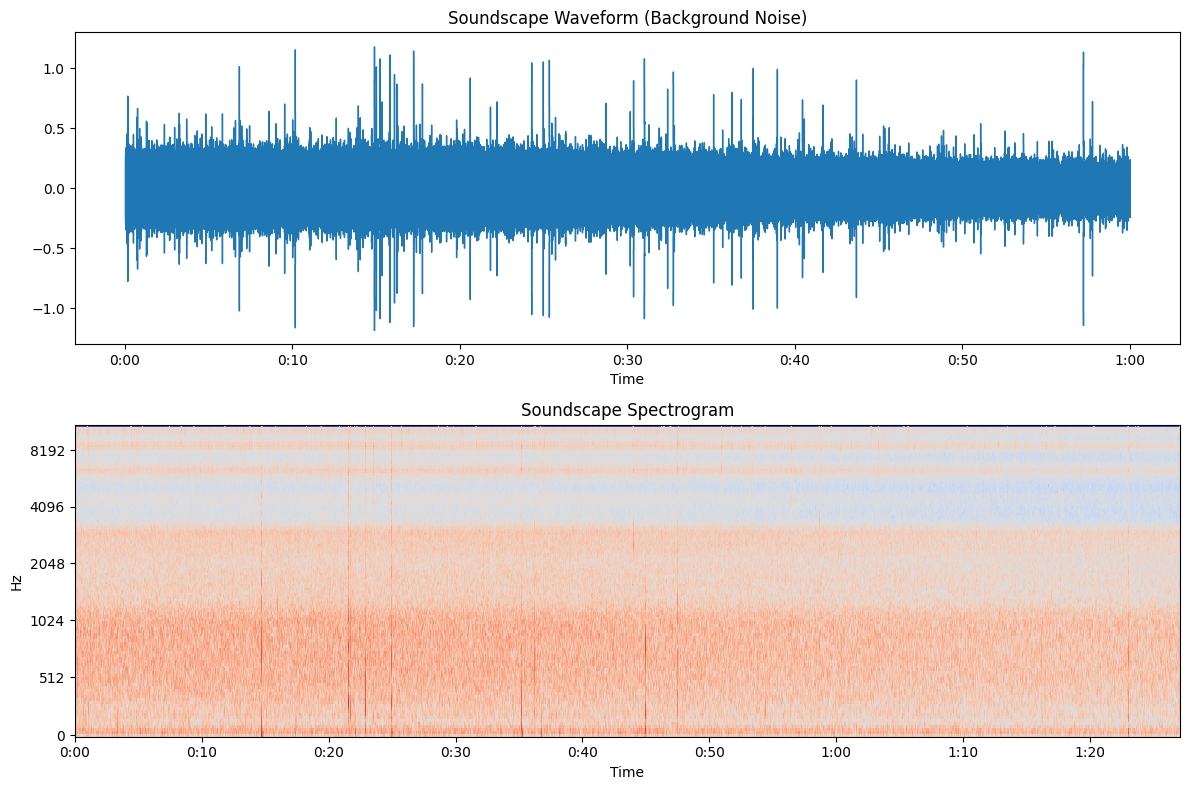

In [8]:
# Load a soundscape
soundscape, sr = librosa.load("/kaggle/input/birdclef-2025/train_soundscapes/H02_20230420_074000.ogg", sr=32000)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(soundscape, sr=sr)
plt.title("Soundscape Waveform (Background Noise)")

plt.subplot(2, 1, 2)
S_soundscape = librosa.feature.melspectrogram(y=soundscape, sr=sr)
librosa.display.specshow(librosa.power_to_db(S_soundscape), x_axis="time", y_axis="mel")
plt.title("Soundscape Spectrogram")
plt.tight_layout()
plt.show()

Compare bg noise in train_audio

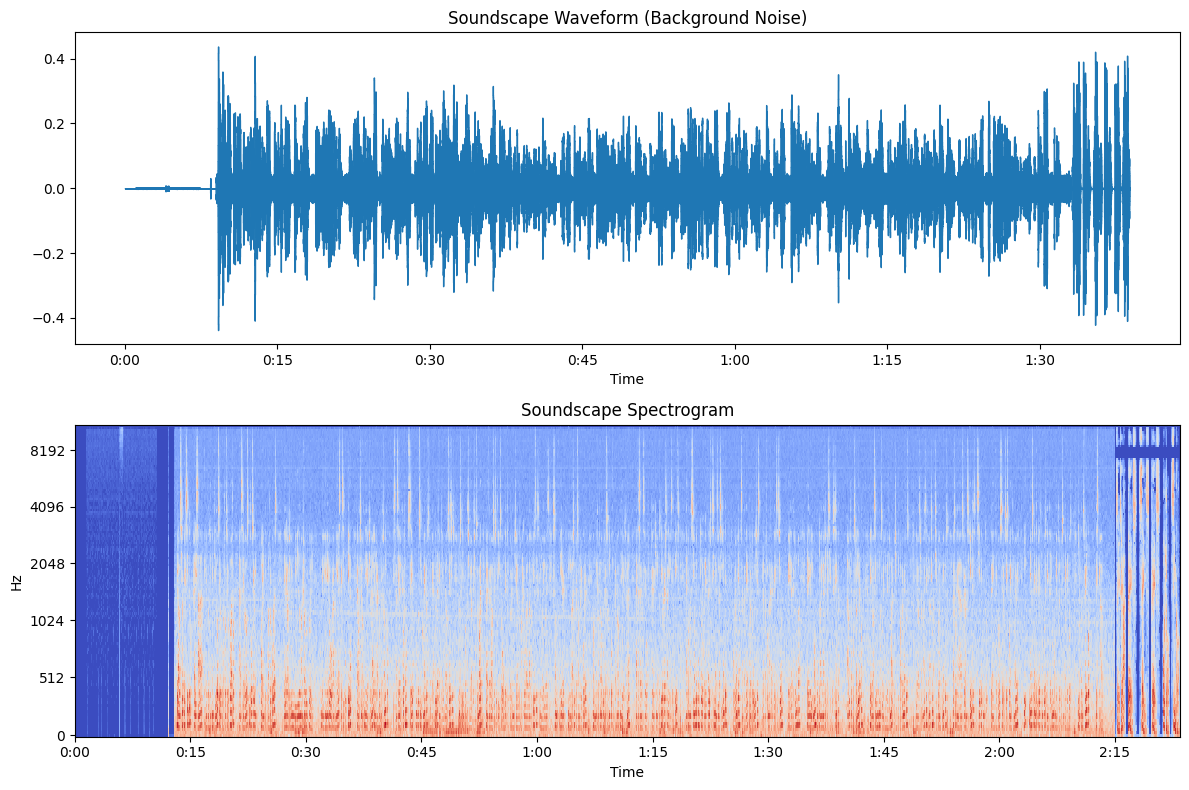

In [9]:
# Load a soundscape
soundscape, sr = librosa.load("/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg", sr=32000)


plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.waveshow(soundscape, sr=sr)
plt.title("Soundscape Waveform (Background Noise)")

plt.subplot(2, 1, 2)
S_soundscape = librosa.feature.melspectrogram(y=soundscape, sr=sr)
librosa.display.specshow(librosa.power_to_db(S_soundscape), x_axis="time", y_axis="mel")
plt.title("Soundscape Spectrogram")
plt.tight_layout()
plt.show()

# **C. Approach / Tips / Guide ------------------>**

## 1. Important Topics You should known 


1. Librosa for audio processing
2. Pytorch/TensorFlow for deep learning
3. Scikit-learn/XGBoost for traditional models
4. TPU/Colab for faster training
5. Audiomentations for data augmentation.


## 2. Approach

In [10]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib  # For saving models

# Paths
TRAIN_AUDIO_PATH = '/kaggle/input/birdclef-2025/train_audio'
TRAIN_CSV_PATH = '/kaggle/input/birdclef-2025/train.csv'
TRAIN_SOUNDSCAPE_PATH = '/kaggle/input/birdclef-2025/train_soundscapes'

# Step 1: Load Data
print("Loading metadata...")
train_df = pd.read_csv(TRAIN_CSV_PATH)

print(f"Number of samples: {len(train_df)}")
print(train_df.head())

Loading metadata...
Number of samples: 28564
  primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name 

In [11]:
# Step 2: Feature Extraction
def extract_features(file_path, n_mfcc=13, fixed_length=100):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Pad or truncate to fixed length
        if mfcc.shape[1] < fixed_length:
            mfcc = np.pad(mfcc, ((0, 0), (0, fixed_length - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_length]
        
        return mfcc.flatten()  # Flatten into a 1D array
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc * fixed_length)  # Return consistent-sized zero array



print("Extracting features (dummy setup with 10 samples)...")
dummy_train_df = train_df.head(10).copy()
dummy_train_df['file_path'] = dummy_train_df['filename'].apply(lambda x: os.path.join(TRAIN_AUDIO_PATH, x))
dummy_train_df['features'] = dummy_train_df['file_path'].apply(extract_features)

# Update the main DataFrame
train_df.loc[dummy_train_df.index, 'features'] = dummy_train_df['features']





#    print("Extracting features...for all Images ")
#    train_df['file_path'] = train_df['filename'].apply(lambda x: os.path.join(TRAIN_AUDIO_PATH, x))
#  train_df['features'] = train_df['file_path'].apply(extract_features)

Extracting features (dummy setup with 10 samples)...


In [12]:

# Prepare input features
X = np.vstack(dummy_train_df['features'].values)
y = dummy_train_df['scientific_name']

# Encode target labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [13]:
# Step 3: Train-Test Split
print("Splitting data...")
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Model Training
print("Training model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

Splitting data...
Training model...


RandomForestClassifier(random_state=42)

In [14]:
# Step 5: Evaluation
print("Evaluating model...")
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# Save the model
joblib.dump(model, 'birdclef_model.pkl')

# Step 6: Generate Submission
def generate_submission(test_audio_folder, model, encoder):
    test_files = os.listdir(test_audio_folder)
    submission = []
    for file in test_files:
        file_path = os.path.join(test_audio_folder, file)
        features = extract_features(file_path).reshape(1, -1)
        pred = model.predict(features)
        label = encoder.inverse_transform(pred)[0]
        submission.append({'row_id': file.split('.')[0], 'birds': label})
    return pd.DataFrame(submission)

print("Generating submission...")
test_audio_path = '/kaggle/input/birdclef-2025/train_audio' 
submission_df = generate_submission(test_audio_path, model, le)
# Save file by removing # from below 
# submission_df.to_csv('submission.csv', index=False)

print("Submission file created.")

Evaluating model...
Validation Accuracy: 0.00
Generating submission...
Error processing /kaggle/input/birdclef-2025/train_audio/greani1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/greani1'
Error processing /kaggle/input/birdclef-2025/train_audio/thbeup1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/thbeup1'
Error processing /kaggle/input/birdclef-2025/train_audio/bkmtou1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/bkmtou1'
Error processing /kaggle/input/birdclef-2025/train_audio/50186: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/50186'
Error processing /kaggle/input/birdclef-2025/train_audio/65962: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/65962'
Error processing /kaggle/input/birdclef-2025/train_audio/linwoo1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/linwoo1'
Error processing /kaggle/input/birdclef-2025/train_audio/yebsee1: [Errno 21] Is

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/rutjac1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/rutjac1'
Error processing /kaggle/input/birdclef-2025/train_audio/yehcar1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/yehcar1'
Error processing /kaggle/input/birdclef-2025/train_audio/42087: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/42087'
Error processing /kaggle/input/birdclef-2025/train_audio/rufmot1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/rufmot1'
Error processing /kaggle/input/birdclef-2025/train_audio/chbant1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/chbant1'
Error processing /kaggle/input/birdclef-2025/train_audio/anhing: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/anhing'
Error processing /kaggle/input/birdclef-2025/train_audio/65349: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/65349'
Error pro

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/66531: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/66531'
Error processing /kaggle/input/birdclef-2025/train_audio/olipic1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/olipic1'
Error processing /kaggle/input/birdclef-2025/train_audio/67252: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/67252'
Error processing /kaggle/input/birdclef-2025/train_audio/gybmar: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/gybmar'
Error processing /kaggle/input/birdclef-2025/train_audio/norscr1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/norscr1'
Error processing /kaggle/input/birdclef-2025/train_audio/y00678: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/y00678'
Error processing /kaggle/input/birdclef-2025/train_audio/555086: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/555086'
Error process

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/purgal2: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/purgal2'
Error processing /kaggle/input/birdclef-2025/train_audio/stbwoo2: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/stbwoo2'
Error processing /kaggle/input/birdclef-2025/train_audio/47067: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/47067'
Error processing /kaggle/input/birdclef-2025/train_audio/ywcpar: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/ywcpar'
Error processing /kaggle/input/birdclef-2025/train_audio/714022: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/714022'
Error processing /kaggle/input/birdclef-2025/train_audio/shtfly1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/shtfly1'
Error processing /kaggle/input/birdclef-2025/train_audio/blcant4: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/blcant4'
Error p

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/1462711: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/1462711'
Error processing /kaggle/input/birdclef-2025/train_audio/tbsfin1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/tbsfin1'
Error processing /kaggle/input/birdclef-2025/train_audio/rumfly1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/rumfly1'
Error processing /kaggle/input/birdclef-2025/train_audio/savhaw1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/savhaw1'
Error processing /kaggle/input/birdclef-2025/train_audio/labter1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/labter1'
Error processing /kaggle/input/birdclef-2025/train_audio/65448: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/65448'
Error processing /kaggle/input/birdclef-2025/train_audio/64862: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/64862'
Error p

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/butsal1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/butsal1'
Error processing /kaggle/input/birdclef-2025/train_audio/548639: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/548639'
Error processing /kaggle/input/birdclef-2025/train_audio/1564122: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/1564122'
Error processing /kaggle/input/birdclef-2025/train_audio/spbwoo1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/spbwoo1'
Error processing /kaggle/input/birdclef-2025/train_audio/bugtan: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/bugtan'
Error processing /kaggle/input/birdclef-2025/train_audio/baymac: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/baymac'
Error processing /kaggle/input/birdclef-2025/train_audio/yecspi2: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/yecspi2'
Error

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

Error processing /kaggle/input/birdclef-2025/train_audio/amakin1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/amakin1'
Error processing /kaggle/input/birdclef-2025/train_audio/65419: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/65419'
Error processing /kaggle/input/birdclef-2025/train_audio/leagre: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/leagre'
Error processing /kaggle/input/birdclef-2025/train_audio/banana: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/banana'
Error processing /kaggle/input/birdclef-2025/train_audio/41970: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/41970'
Error processing /kaggle/input/birdclef-2025/train_audio/21211: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/21211'
Error processing /kaggle/input/birdclef-2025/train_audio/rubsee1: [Errno 21] Is a directory: '/kaggle/input/birdclef-2025/train_audio/rubsee1'
Error processin

/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_13/3455618309.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages

## 3. Resoucres

https://librosa.org/doc/latest/index.html

https://www.coursera.org/learn/audio-signal-processing

https://towardsdatascience.com/audio-feature-extraction-in-python-a-step-by-step-guide-87f4ccfb73cd

# D. Statistics

# **1. Descriptive Statistics------------->**

## **1. Missing Values**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr

# Load the dataset
data = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")

print("Descriptive Statistics:")
print(data.describe(include='all')) 
print("\nMissing Values:")
print(data.isnull().sum()) 

Descriptive Statistics:
       primary_label secondary_labels      type              filename  \
count          28564            28564     28564                 28564   
unique           206              745       736                 28564   
top           grekis             ['']  ['song']  1139490/CSA36385.ogg   
freq             990            25885      9437                     1   
mean             NaN              NaN       NaN                   NaN   
std              NaN              NaN       NaN                   NaN   
min              NaN              NaN       NaN                   NaN   
25%              NaN              NaN       NaN                   NaN   
50%              NaN              NaN       NaN                   NaN   
75%              NaN              NaN       NaN                   NaN   
max              NaN              NaN       NaN                   NaN   

       collection        rating  \
count       28564  28564.000000   
unique          3           N

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## 2. Distribution of Ratiings

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


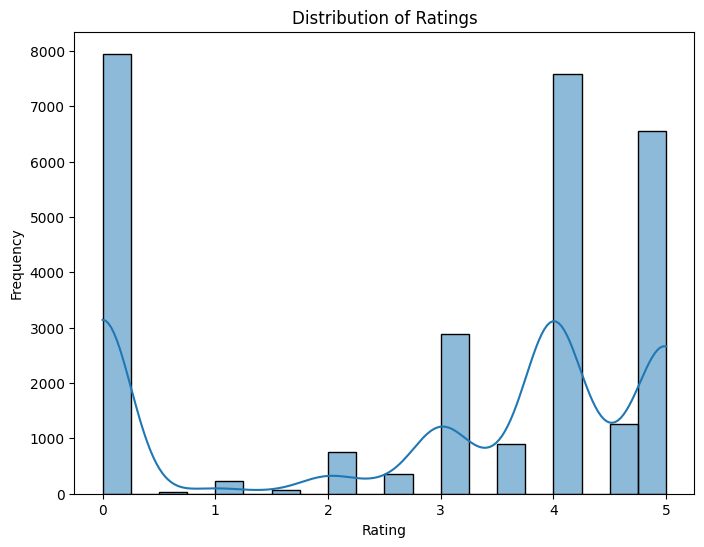

In [16]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(data['rating'], kde=True, bins=20)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

## 3. Frequency of Scientific Names

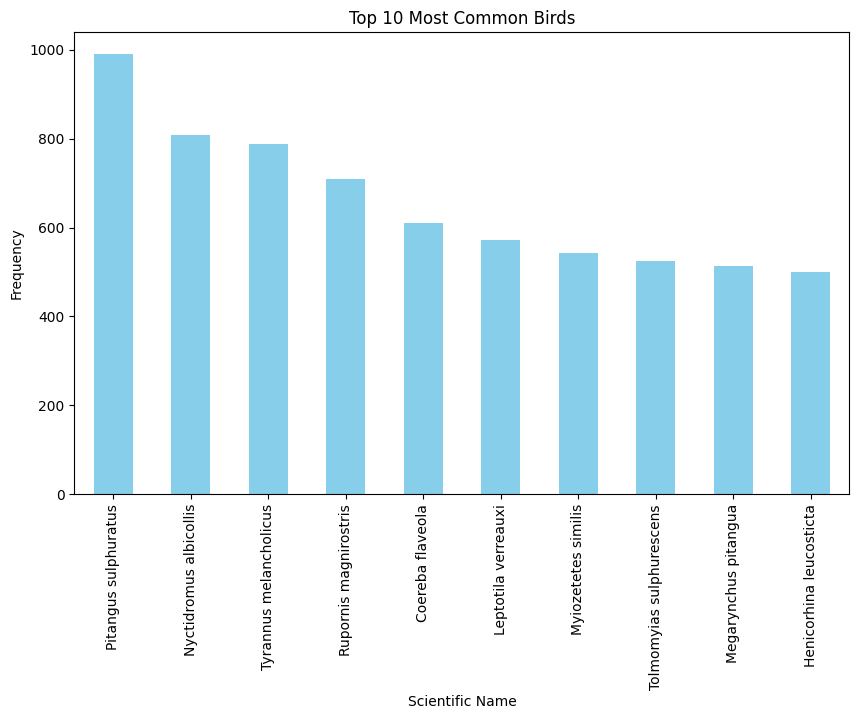

In [17]:
# Frequency of scientific names
top_scientific_names = data['scientific_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_scientific_names.plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Common Birds")
plt.xlabel("Scientific Name")
plt.ylabel("Frequency")
plt.show()

## 4. Geospatial Destribution

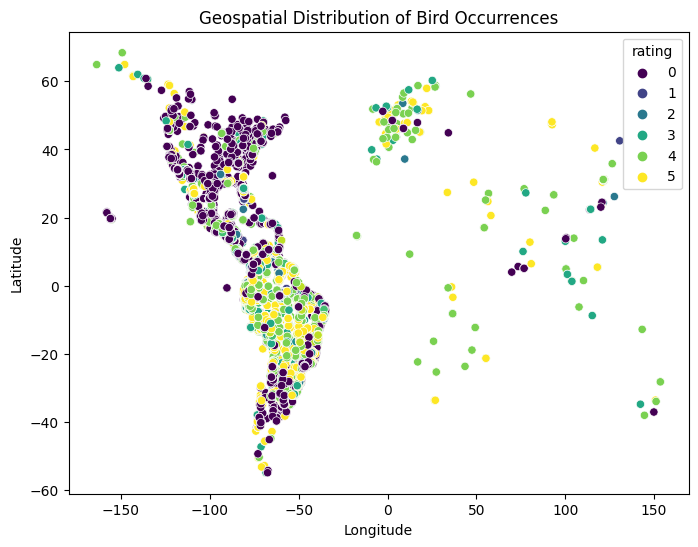

In [18]:
# Geospatial Distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['longitude'], y=data['latitude'], hue=data['rating'], palette="viridis")
plt.title("Geospatial Distribution of Bird Occurrences")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# **2. Infrential ------------------->**

## 1. Hypothethis Testing: Does rating differ significantly between collections?

In [19]:

collections = data['collection'].unique()
ratings_by_collection = [data[data['collection'] == col]['rating'] for col in collections]

if len(collections) > 2:
    # ANOVA for more than two groups
    f_stat, p_value = f_oneway(*ratings_by_collection)
    print("\nANOVA Test Results:")
    print(f"F-statistic: {f_stat}, P-value: {p_value}")
else:
    # T-test for two groups
    t_stat, p_value = ttest_ind(ratings_by_collection[0], ratings_by_collection[1])
    print("\nT-Test Results:")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")


ANOVA Test Results:
F-statistic: 46499.56277863355, P-value: 0.0


## 2. Correlation Analysis between latitude, longitude, and rating

In [20]:

pearson_corr_lat, _ = pearsonr(data['latitude'], data['rating'])
pearson_corr_lon, _ = pearsonr(data['longitude'], data['rating'])
print("\nCorrelation Analysis:")
print(f"Pearson Correlation (Latitude vs Rating): {pearson_corr_lat}")
print(f"Pearson Correlation (Longitude vs Rating): {pearson_corr_lon}")


Correlation Analysis:
Pearson Correlation (Latitude vs Rating): nan
Pearson Correlation (Longitude vs Rating): nan


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4637: RuntimeWarning: invalid value encountered in less
  nconst_x = xp.any(normxm < threshold*xp.abs(xmean), axis=axis)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:354: RuntimeWarning: invalid value encountered in less
  ia = (out < a) | xp.isnan(a)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:361: RuntimeWarning: invalid value encountered in greater
  ib = (out > b) | xp.isnan(b)
